# 04_1: BERT Modeling - Snorkel Labeled

***Following codes were run in Google Colab** 
\
***File paths were modified for local application**


---

## Install & Imports

In [1]:
!pip install -q tensorflow_text

     |████████████████████████████████| 4.6 MB 8.6 MB/s 
     |████████████████████████████████| 511.7 MB 5.5 kB/s 
     |████████████████████████████████| 438 kB 51.1 MB/s 
     |████████████████████████████████| 1.6 MB 38.8 MB/s 
     |████████████████████████████████| 5.8 MB 39.7 MB/s 


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.callbacks import EarlyStopping

In [35]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


## Load Data

In [6]:
tweets_train = pd.read_csv('../data/snorklabeled_tweets_train.csv')
tweets_train.head()

,datetime,text,label
0,2021-01-20 23:59:58+00:00,@acevenvevo @ADM_Briggs @Anthony37662002 @Vibe...,1
1,2021-01-20 23:59:52+00:00,Please read this important thread from my offi...,1
2,2021-01-20 23:59:42+00:00,Just saw two homeless people giving themselves...,1
3,2021-01-20 23:59:38+00:00,Santa Cruz County says the goal is to distribu...,1
4,2021-01-20 23:59:25+00:00,Amazon offers to help Biden speed delivery of ...,1


In [7]:
tweets_train.shape

(60515, 3)

In [8]:
tweets_train['label'].value_counts()

1    52252
0     8263
Name: label, dtype: int64

In [9]:
tweets_train['label'].value_counts(normalize=True)

1    0.863455
0    0.136545
Name: label, dtype: float64

The dataset is highly imbalanced due to low coverage of class 0 labeling function. I will choose to undersample as a baseline to reduce the time of training. 

**Undersampling**

In [10]:
# split the dataset by their classes 
novax = tweets_train[tweets_train['label']==0]
yesvax = tweets_train[tweets_train['label']==1]

In [11]:
# down sample the majority class to match the shape of the minority class
yesvax_ds = yesvax.sample(novax.shape[0])

In [12]:
# put together the dataframe
tweets_balanced_ds = pd.concat([yesvax_ds, novax])
tweets_balanced_ds.shape

(16526, 3)

**train-Val Split**

In [13]:
X = tweets_balanced_ds['text']
y = tweets_balanced_ds['label']

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, stratify=y)

<font color='red'>For model integrity, the train/validation set should have been split BEFORE undersampling the training set.</font>

By making validation dataset also balanced, it is impossible to check how the imbalance in the dataset would affect the prediction.

---

## BERT Modeling

In [15]:
# Import BERT model from Tensorflow hub
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [21]:
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0,
                           patience=5,
                           verbose=1
                           )

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [22]:
history = model.fit(X_train, y_train, 
                    validation_data = (X_val, y_val),
                    epochs=10,
                    callbacks=[early_stop]
                    )

Epoch 1/10
388/388 [==============================] - 178s 433ms/step - loss: 0.5776 - accuracy: 0.7098 - precision: 0.7130 - recall: 0.7021 - val_loss: 0.5362 - val_accuracy: 0.7488 - val_precision: 0.7649 - val_recall: 0.7183
Epoch 2/10
388/388 [==============================] - 174s 449ms/step - loss: 0.5368 - accuracy: 0.7434 - precision: 0.7595 - recall: 0.7124 - val_loss: 0.5494 - val_accuracy: 0.7062 - val_precision: 0.6644 - val_recall: 0.8335
Epoch 3/10
388/388 [==============================] - 175s 451ms/step - loss: 0.5220 - accuracy: 0.7504 - precision: 0.7686 - recall: 0.7165 - val_loss: 0.5202 - val_accuracy: 0.7369 - val_precision: 0.7102 - val_recall: 0.8006
Epoch 4/10
388/388 [==============================] - 175s 452ms/step - loss: 0.5145 - accuracy: 0.7517 - precision: 0.7701 - recall: 0.7178 - val_loss: 0.5000 - val_accuracy: 0.7715 - val_precision: 0.8347 - val_recall: 0.6772
Epoch 5/10
388/388 [==============================] - 175s 451ms/step - loss: 0.5064 - a

**Save history and model for later usage and evaluation**

In [32]:
# save history data into csv
history_df = pd.DataFrame.from_dict(history.history)

In [33]:
pd.DataFrame.from_dict(history.history).to_csv("../nn_history/snorkel_model.csv", index=False)

In [16]:
# save model
model_path = "../nn_model/snorkel_model"

In [35]:
model.save(model_path)

In [17]:
model_reload = tf.keras.models.load_model(model_path)

**Test the model**

In [28]:
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Projects/Capstone/data/snorklabeled_tweets_test.csv")

In [29]:
test.sample(5000, random_state=42)['label'].value_counts(normalize=True)

1    0.866
0    0.134
Name: label, dtype: float64

In [30]:
test = test.sample(5000, random_state=42)

In [31]:
X_test = test['text']
y_test = test['label']

In [33]:
y_pred = model_reload.predict(X_test)

157/157 [==============================] - 2239s 14s/step


In [34]:
y_pred_class = y_pred.flatten()
y_pred_class = np.where(y_pred_class > 0.5, 1, 0)

In [36]:

cm = confusion_matrix(y_test, y_pred_class)
cm 

array([[ 607,   63],
       [1426, 2904]])

Text(33.0, 0.5, 'Truth')

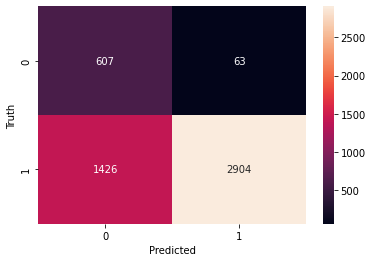

In [37]:
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [39]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.30      0.91      0.45       670
           1       0.98      0.67      0.80      4330

    accuracy                           0.70      5000
   macro avg       0.64      0.79      0.62      5000
weighted avg       0.89      0.70      0.75      5000



As discussed earlier, test set accuracy went down likely due to balancing the data before train/validation set. Considering the baseline score of 0.8, the model performed poorly. Also, out of the anti_vax predicted data, more than 2/3 are actually pro_vax(according to Snorkel label).

Anyhow, as comparable to its computing time, the model as it is is no better, if not worse than the TF-IDF vectorized model. Due to the shortage of Colab GPU usage and to consider time effeciency, I will focus more on TF-ODEFvectorizer model. 